In [1]:
import numpy as np
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('energy_demand.xlsx')
print(df)


            Date  Hour    load          T
0     2012-01-01     0  2872.0  30.666667
1     2012-01-01     1  2698.0  32.000000
2     2012-01-01     2  2558.0  32.666667
3     2012-01-01     3  2444.0  30.000000
4     2012-01-01     4  2402.0  31.000000
...          ...   ...     ...        ...
26300 2014-12-31    20  4012.0  18.000000
26301 2014-12-31    21  3856.0  16.666667
26302 2014-12-31    22  3671.0  17.000000
26303 2014-12-31    23  3499.0  15.333333
26304 2014-12-31    24  3345.0  15.333333

[26305 rows x 4 columns]


In [3]:
# Convert to datetime, considering "24" as "0" of the next day
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Hour'].astype(str) + ':00:00', errors='coerce')

# Adjust the hour for values equal to 24 and increment the date
mask = df['Hour'] == 24
df.loc[mask, 'Datetime'] = pd.to_datetime(df.loc[mask, 'Date'].astype(str) + ' 00:00:00', errors='coerce') + pd.DateOffset(days=1)

# Drop the original columns if needed
df = df.drop(['Date', 'Hour'], axis=1)
df.set_index('Datetime', inplace=True)
print(df.head(300))

                       load          T
Datetime                              
2012-01-01 00:00:00  2872.0  30.666667
2012-01-01 01:00:00  2698.0  32.000000
2012-01-01 02:00:00  2558.0  32.666667
2012-01-01 03:00:00  2444.0  30.000000
2012-01-01 04:00:00  2402.0  31.000000
...                     ...        ...
2012-01-13 07:00:00  3418.0  30.000000
2012-01-13 08:00:00  3681.0  29.333333
2012-01-13 09:00:00  3768.0  29.333333
2012-01-13 10:00:00  3818.0  30.333333
2012-01-13 11:00:00  3856.0  30.666667

[300 rows x 2 columns]


In [4]:
print(df.isnull().sum())

load    0
T       0
dtype: int64


## Transform data to tabular format (x and y)

In [5]:
def sliding_window(data, window_size, horizon=1):
    """Performs a sliding window on a time series.

    Args:
      data: A Pandas DataFrame with a single column containing the time series data.
      window_size: The size of the sliding window.
      horizon: The number of steps to forecast into the future.

    Returns:
      X: Input features (2D array)
      y: Target labels (1D array)
    """
  
    X, y = [], []
    for i in range(0, len(data) - window_size - horizon + 1):
        window = data.iloc[i:i + window_size].values  # Extract the series values directly
        target = data.iloc[i + window_size + horizon - 1]  # Target is horizon steps ahead

        X.append(window)
        y.append(target)
    
    return np.array(X), np.array(y)




## Single-Step (Models)

In [6]:
#train/split

window = 6
horizon = 1

X, y = sliding_window(df['load'], window, horizon)


split_ratio = 0.8
split_index = int(split_ratio * len(df))

print(X.shape)
print(y.shape)

X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]

(26299, 6)
(26299,)


### Linear Regression

In [7]:
# Create and train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_single_lr = model.predict(X_test)

# Evaluate the model on the test set
mse_single_lr = mean_squared_error(y_test, y_pred_single_lr)
print(f'Mean Squared Error on Test Set(Linear regression): {mse_single_lr}')

# Calculate Mean Absolute Error (MAE)
mae_single_lr = mean_absolute_error(y_test, y_pred_single_lr)
print(f'Mean Absolute Error on Test Set (Linear Regression): {mae_single_lr}')

# Calculate Root Mean Squared Error (RMSE)
rmse_single_lr = np.sqrt(mean_squared_error(y_test, y_pred_single_lr))
print(f'Root Mean Squared Error on Test Set (Linear Regression): {rmse_single_lr}')


Mean Squared Error on Test Set(Linear regression): 5118.261614769476
Mean Absolute Error on Test Set (Linear Regression): 50.910690401281386
Root Mean Squared Error on Test Set (Linear Regression): 71.54202691264399


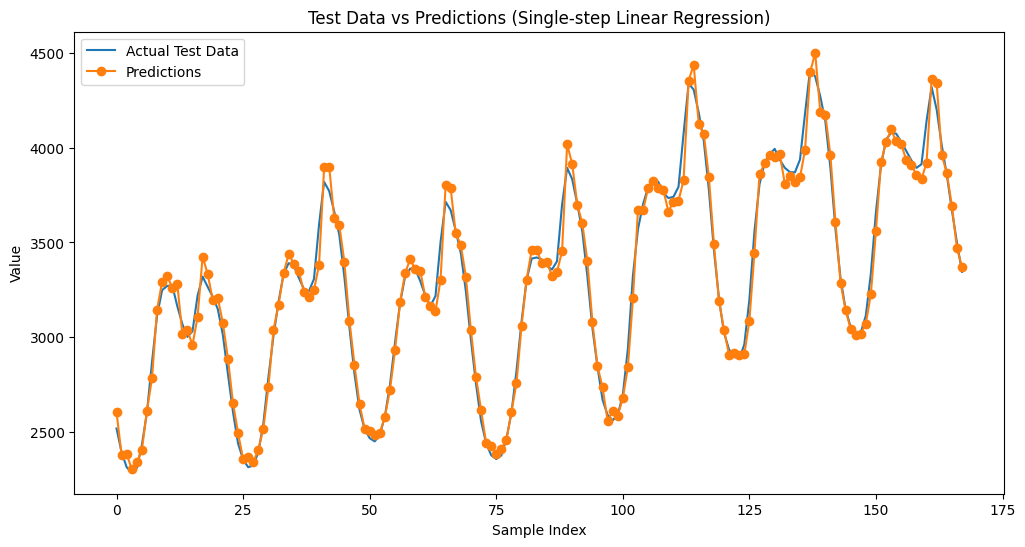

In [26]:
#ploting linear regresison
last_week = -168

plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Actual Test Data' )
plt.plot(y_pred_single_lr[last_week:], label='Predictions',  marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test Data vs Predictions (Single-step Linear Regression)')
plt.legend()
plt.show()

### KNN


In [9]:
# # Store MSE values for different numbers of neighbors
# mse_values = []

# # Test multiple numbers of neighbors
# for n_neighbors in range(3, 32, 2):  # Odd numbers from 3 to 31
#     # KNN model
#     knn_model = KNeighborsRegressor(n_neighbors=n_neighbors)
#     knn_model.fit(X_train, y_train)

#     # Predictions on the test set
#     y_pred_knn = knn_model.predict(X_test)

#     # Calculate MSE
#     mse_knn = mean_squared_error(y_test, y_pred_knn)
#     mse_values.append((n_neighbors, mse_knn))
#     print(f'KNN Test MSE with {n_neighbors} neighbors: {mse_knn}')

# # Extract values for plotting
# neighbors, mse_values = zip(*mse_values)

# # Plot the MSE values in a bar plot
# plt.bar(neighbors, mse_values, color='blue')
# plt.xlabel('Number of Neighbors')
# plt.ylabel('Mean Squared Error')
# plt.title('MSE for Different Numbers of Neighbors')
# plt.show()

In [10]:
# KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predictions on the test set
y_pred_knn_single = knn_model.predict(X_test)

# Calculate MSE
mse_knn_single = mean_squared_error(y_test, y_pred_knn_single)
print(f'KNN Test MSE: {mse_knn_single}')

# Calculate Mean Absolute Error (MAE)
mae_knn_single = mean_absolute_error(y_test, y_pred_knn_single)
print(f'Mean Absolute Error on Test Set (Linear Regression): {mae_knn_single}')

# Calculate Root Mean Squared Error (RMSE)
rmse_knn_single = np.sqrt(mean_squared_error(y_test, y_pred_knn_single))
print(f'Root Mean Squared Error on Test Set (Linear Regression): {rmse_knn_single}')

KNN Test MSE: 3833.7449800190298
Mean Absolute Error on Test Set (Linear Regression): 41.618705994291155
Root Mean Squared Error on Test Set (Linear Regression): 61.91724299433099


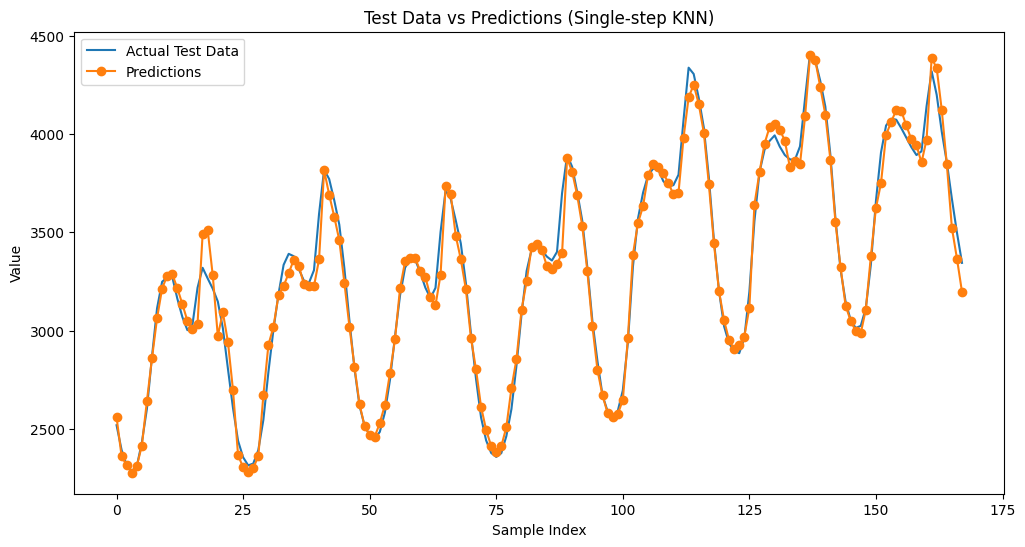

In [27]:
#plotting knn
last_week = -168
plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Actual Test Data' )
plt.plot(y_pred_knn_single[last_week:], label='Predictions', marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test Data vs Predictions (Single-step KNN)')
plt.legend()
plt.show()

### SVR (Support Vector Regressor)

In [12]:
# SVR requires feature scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.flatten().reshape(-1, 1)).flatten()

X_test_scaled = scaler_X.transform(X_test)

# SVR model
svr_model = SVR(kernel='rbf')  # Radial basis function (RBF) kernel
svr_model.fit(X_train_scaled, y_train_scaled)

# Predictions on the scaled test set
y_pred_svr_scaled = svr_model.predict(X_test_scaled)

# Invert scaling for comparison
y_pred_svr_single = scaler_y.inverse_transform(y_pred_svr_scaled.reshape(-1, 1))

# Calculate MSE
mse_svr_single = mean_squared_error(y_test.flatten(), y_pred_svr_single)
print(f'SVR Test MSE: {mse_svr_single}')


# Calculate Mean Absolute Error (MAE) for SVR
mae_svr_single = mean_absolute_error(y_test.flatten(), y_pred_svr_single)
print(f'SVR Test MAE: {mae_svr_single}')

# Calculate Root Mean Squared Error (RMSE) for SVR
rmse_svr_single = np.sqrt(mean_squared_error(y_test.flatten(), y_pred_svr_single))
print(f'SVR Test RMSE: {rmse_svr_single}')

SVR Test MSE: 3045.622318470337
SVR Test MAE: 37.53055386664149
SVR Test RMSE: 55.18715718779449


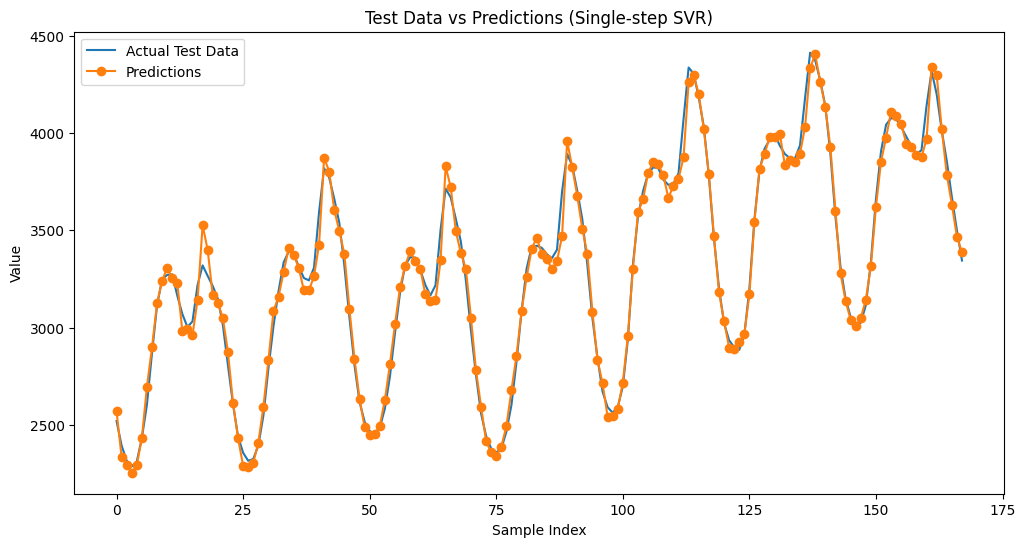

In [28]:
#plotting knn
last_week = -168
plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Actual Test Data', )
plt.plot(y_pred_svr_single[last_week:], label='Predictions', marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test Data vs Predictions (Single-step SVR)')
plt.legend()
plt.show()

### XGBoost

In [14]:
# Create and train an XGBoost model
model = xgb.XGBRegressor(objective ='reg:squarederror') # you can customize parameters based on your problem
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_single_XGB = model.predict(X_test)

# Evaluate the model on the test set
mse_single_XGB = mean_squared_error(y_test, y_pred_single_XGB)
print(f'Mean Squared Error on Test Set(XGBoost): {mse_single_XGB}')

# Calculate Mean Absolute Error (MAE) for XGBoost
mae_single_XGB = mean_absolute_error(y_test, y_pred_single_XGB)
print(f'XGBoost Test MAE: {mae_single_XGB}')

# Calculate Root Mean Squared Error (RMSE) for XGBoost
rmse_single_XGB = np.sqrt(mean_squared_error(y_test, y_pred_single_XGB))
print(f'XGBoost Test RMSE: {rmse_single_XGB}')

Mean Squared Error on Test Set(XGBoost): 3282.3065870836504
XGBoost Test MAE: 38.584159152741435
XGBoost Test RMSE: 57.29141809279685


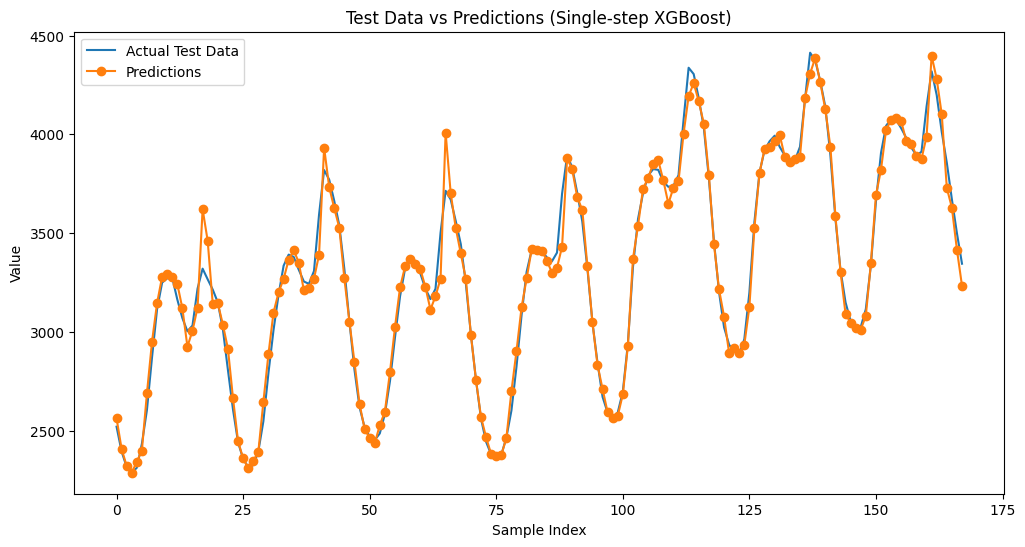

In [29]:
# Plotting the last 200 rows of actual test data and predictions
last_week = -168
plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Actual Test Data' )
plt.plot(y_pred_single_XGB[last_week:], label='Predictions', marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test Data vs Predictions (Single-step XGBoost)')
plt.legend()
plt.show()

### Light Gradient Boosting (LGB)

In [16]:
# Create and train a LightGBM model
model_lgb = lgb.LGBMRegressor(objective='regression', metric='mse')  # You can customize parameters based on your problem
model_lgb.fit(X_train, y_train)

# Make predictions on the test set
y_pred_single_lgb = model_lgb.predict(X_test)

# Evaluate the model on the test set
mse_single_lgb = mean_squared_error(y_test, y_pred_single_lgb)
print(f'Mean Squared Error on Test Set (LightGBM): {mse_single_lgb}')

# Calculate Mean Absolute Error (MAE) for LightGBM
mae_single_lgb = mean_absolute_error(y_test, y_pred_single_lgb)
print(f'LightGBM Test MAE: {mae_single_lgb}')

# Calculate Root Mean Squared Error (RMSE) for LightGBM
rmse_single_lgb = np.sqrt(mean_squared_error(y_test, y_pred_single_lgb))
print(f'LightGBM Test RMSE: {rmse_single_lgb}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 21044, number of used features: 6
[LightGBM] [Info] Start training from score 3301.757461
Mean Squared Error on Test Set (LightGBM): 3302.042612029404
LightGBM Test MAE: 39.06888228834715
LightGBM Test RMSE: 57.46340237080819


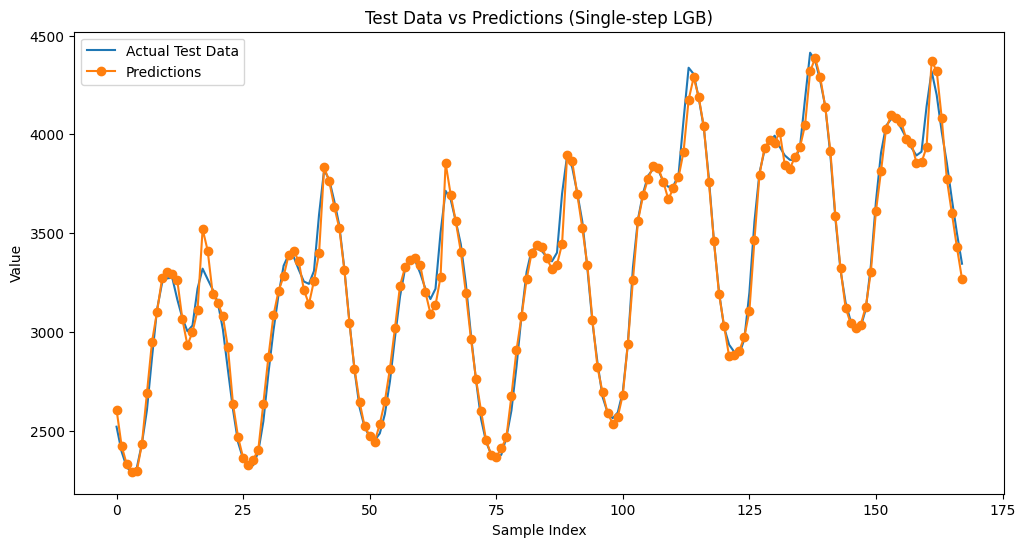

In [30]:
# Plotting the last 200 rows of actual test data and predictions
last_week = -168
plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Actual Test Data' )
plt.plot(y_pred_single_lgb[last_week:], label='Predictions', marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test Data vs Predictions (Single-step LGB)')
plt.legend()
plt.show()

### Gradient Boosting


In [18]:
# Create and train a Gradient Boosting model
model_gb = GradientBoostingRegressor()  # You can customize parameters based on your problem
model_gb.fit(X_train, y_train)

# Make predictions on the test set
y_pred_single_gb = model_gb.predict(X_test)

# Evaluate the model on the test set
mse_single_gb = mean_squared_error(y_test, y_pred_single_gb)
print(f'Mean Squared Error on Test Set (Gradient Boosting): {mse_single_gb}')

# Calculate Mean Absolute Error (MAE) for Gradient Boosting
mae_single_gb = mean_absolute_error(y_test, y_pred_single_gb)
print(f'Gradient Boosting Test MAE: {mae_single_gb}')

# Calculate Root Mean Squared Error (RMSE) for Gradient Boosting
rmse_single_gb = np.sqrt(mean_squared_error(y_test, y_pred_single_gb))
print(f'Gradient Boosting Test RMSE: {rmse_single_gb}')

Mean Squared Error on Test Set (Gradient Boosting): 5557.907872251603
Gradient Boosting Test MAE: 53.47011552310795
Gradient Boosting Test RMSE: 74.5513774000964


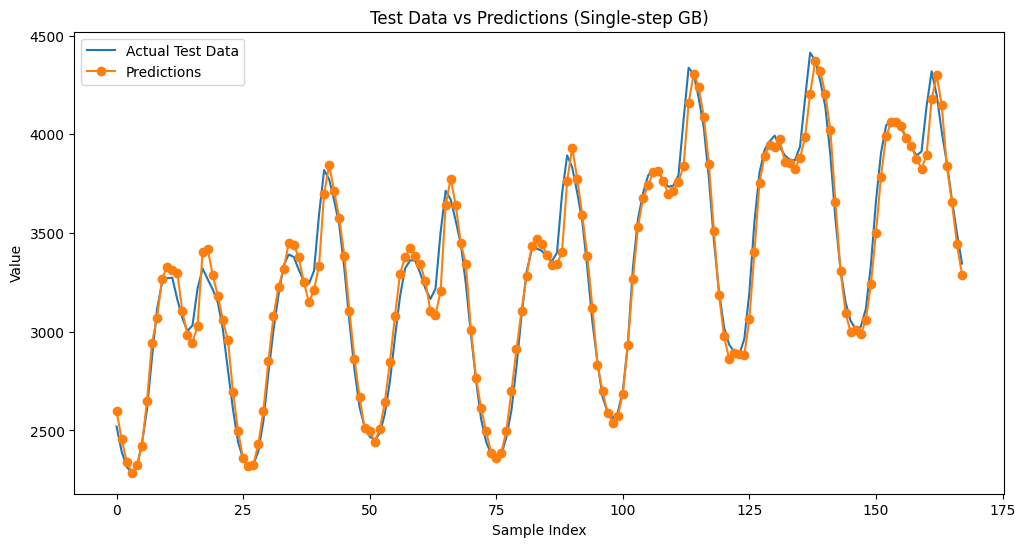

In [31]:
# Plotting the last 200 rows of actual test data and predictions
last_week = -168
plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Actual Test Data' )
plt.plot(y_pred_single_gb[last_week:], label='Predictions', marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test Data vs Predictions (Single-step GB)')
plt.legend()
plt.show()

### Neural Networks

In [20]:
# Standardize the input features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).flatten()


# Create a neural network regressor model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer with 1 neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2)

# Make predictions on the test set
y_pred_single_NN = model.predict(X_test_scaled).flatten()

y_pred_single_NN = scaler.inverse_transform(y_pred_single_NN.reshape(-1, 1)).flatten()


# Evaluate the model on the test set
mse_single_NN = mean_squared_error(y_test, y_pred_single_NN)
print(f'Mean Squared Error on Test Set: {mse_single_NN}')

# Calculate Mean Absolute Error (MAE) for Neural Network
mae_single_NN = mean_absolute_error(y_test, y_pred_single_NN)
print(f'Neural Network Test MAE: {mae_single_NN}')

# Calculate Root Mean Squared Error (RMSE) for Neural Network
rmse_single_NN = np.sqrt(mean_squared_error(y_test, y_pred_single_NN))
print(f'Neural Network Test RMSE: {rmse_single_NN}')



Epoch 1/50

527/527 [==============================] - 3s 3ms/step - loss: 0.0069 - val_loss: 0.0011
Epoch 2/50
527/527 [==============================] - 1s 2ms/step - loss: 7.2106e-04 - val_loss: 6.0406e-04
Epoch 3/50
527/527 [==============================] - 1s 2ms/step - loss: 5.5192e-04 - val_loss: 7.8566e-04
Epoch 4/50
527/527 [==============================] - 1s 2ms/step - loss: 4.7737e-04 - val_loss: 4.8989e-04
Epoch 5/50
527/527 [==============================] - 1s 2ms/step - loss: 4.4048e-04 - val_loss: 4.3087e-04
Epoch 6/50
527/527 [==============================] - 1s 2ms/step - loss: 4.3796e-04 - val_loss: 4.3082e-04
Epoch 7/50
527/527 [==============================] - 1s 2ms/step - loss: 4.3053e-04 - val_loss: 5.0682e-04
Epoch 8/50
527/527 [==============================] - 1s 2ms/step - loss: 4.2716e-04 - val_loss: 4.5140e-04
Epoch 9/50
527/527 [==============================] - 1s 2ms/step - loss: 3.8888e-04 - val_loss: 4.1241e-04
Epoch 10/50
527/527 [============

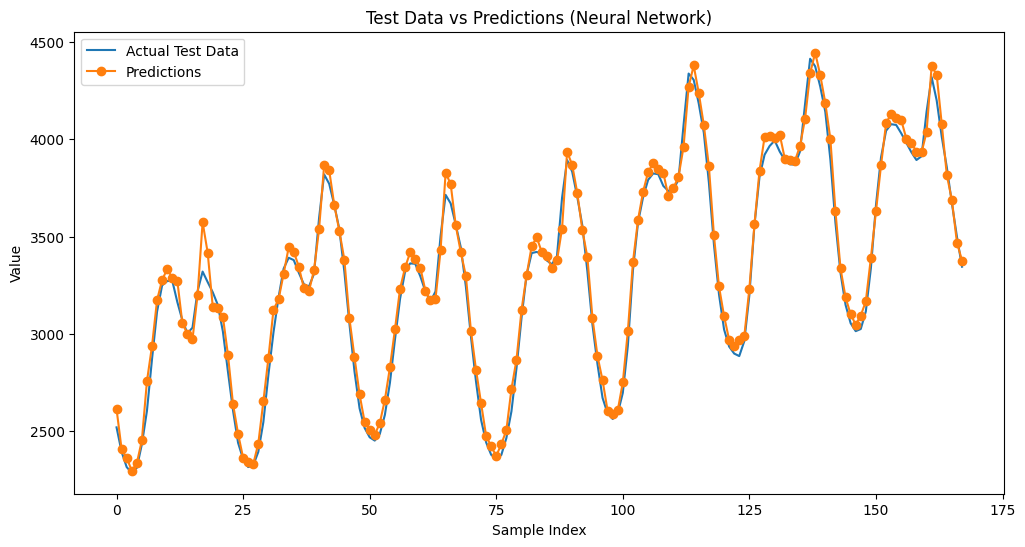

In [32]:
# Plotting the last 200 rows of actual test data and predictions
last_week = -168

plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Actual Test Data')
plt.plot(y_pred_single_NN[last_week:], label='Predictions', marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test Data vs Predictions (Neural Network)')
plt.legend()
plt.show()

### Random Forest Regressor

In [22]:
# Train Random Forest Regressor
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
y_pred_single_rf = model_rf.predict(X_test)

# Evaluate the model on the test set
mse_single_random = mean_squared_error(y_test, y_pred_single_rf)
print(f'Mean Squared Error on Test Set(Random Forest): {mse_single_random}')

# Calculate Mean Absolute Error (MAE) for Random Forest
mae_single_rf = mean_absolute_error(y_test, y_pred_single_rf)
print(f'Random Forest Test MAE: {mae_single_rf}')

# Calculate Root Mean Squared Error (RMSE) for Random Forest
rmse_single_rf = np.sqrt(mean_squared_error(y_test, y_pred_single_rf))
print(f'Random Forest Test RMSE: {rmse_single_rf}')

Mean Squared Error on Test Set(Random Forest): 2742.868314062797
Random Forest Test MAE: 34.047737392959085
Random Forest Test RMSE: 52.37240030839523


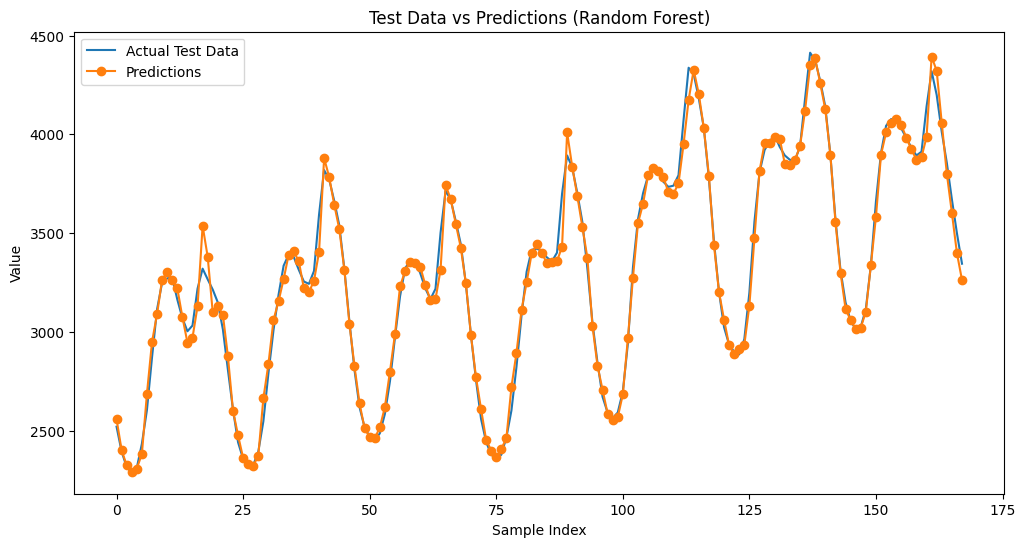

In [33]:
# Plotting the last 200 rows of actual test data and predictions
last_week = -168

plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Actual Test Data')
plt.plot(y_pred_single_rf[last_week:], label='Predictions', marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test Data vs Predictions (Random Forest)')
plt.legend()
plt.show()

## MSE Comparison (Single-step)

Model: Random Forest with MSE = 2742.868314062797
Model: Neural Network with MSE = 4617.886797159292
Model: Gradient Boosting with MSE = 5557.907872251603
Model: LightGBM with MSE = 3302.042612029404
Model: XGBoost with MSE = 3282.3065870836504
Model: SVR with MSE = 3045.622318470337
Model: KNN with MSE = 3833.7449800190298
Model: Linear Regression with MSE = 5118.261614769476


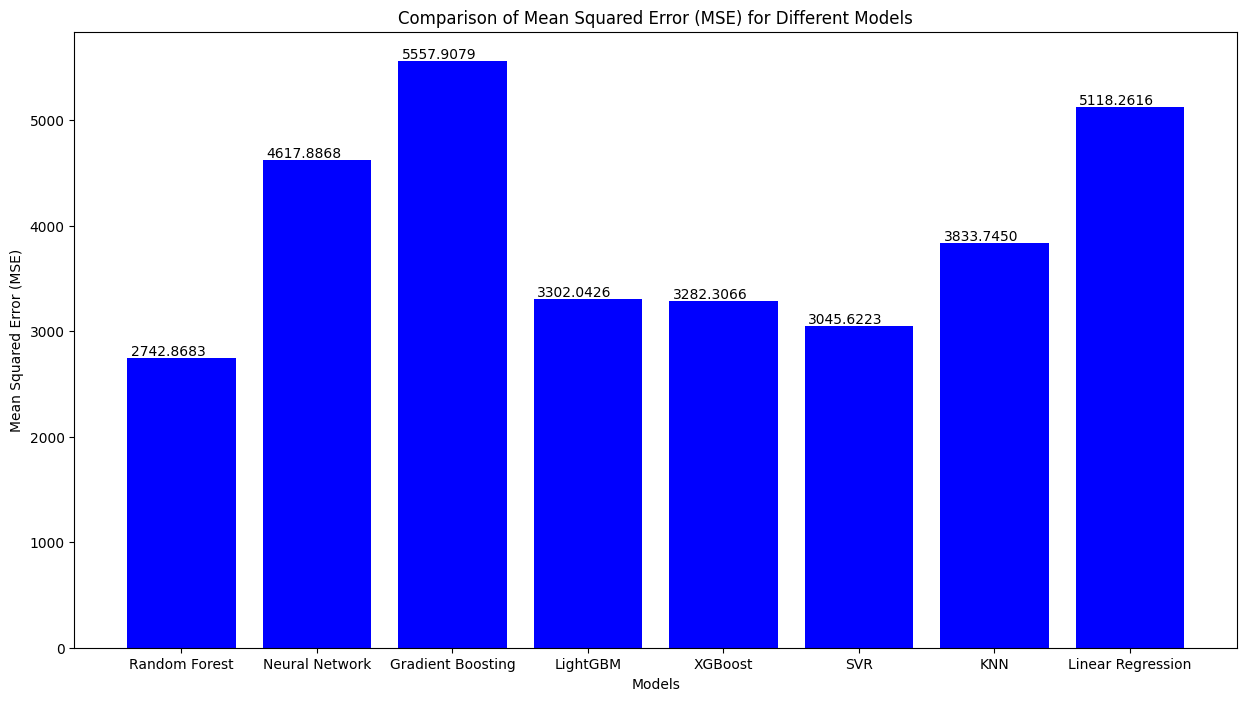

In [35]:
single_mse = [mse_single_random, mse_single_NN, mse_single_gb, mse_single_lgb, mse_single_XGB, mse_svr_single, mse_knn_single, mse_single_lr]

models = ['Random Forest', 'Neural Network', 'Gradient Boosting', 'LightGBM', 'XGBoost', 'SVR', 'KNN', 'Linear Regression']

for m, metric in zip(models, single_mse):
    print(f'Model: {m} with MSE = {metric}')

# Create a bar plot
plt.figure(figsize=(15, 8))
bars = plt.bar(models, single_mse, color='blue')
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Mean Squared Error (MSE) for Different Models')

# Add values on top of the bars
for bar, value in zip(bars, single_mse):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f'{value:.4f}', ha='center', va='bottom')

plt.show()

### MAE and RMSE comparison (Single-step)

Model: Random Forest, MAE: 34.0477, RMSE: 52.3724
Model: Neural Network, MAE: 51.1507, RMSE: 67.9550
Model: Gradient Boosting, MAE: 53.4701, RMSE: 74.5514
Model: LightGBM, MAE: 39.0689, RMSE: 57.4634
Model: XGBoost, MAE: 38.5842, RMSE: 57.2914
Model: SVR, MAE: 37.5306, RMSE: 55.1872
Model: KNN, MAE: 41.6187, RMSE: 61.9172
Model: Linear Regression, MAE: 50.9107, RMSE: 71.5420


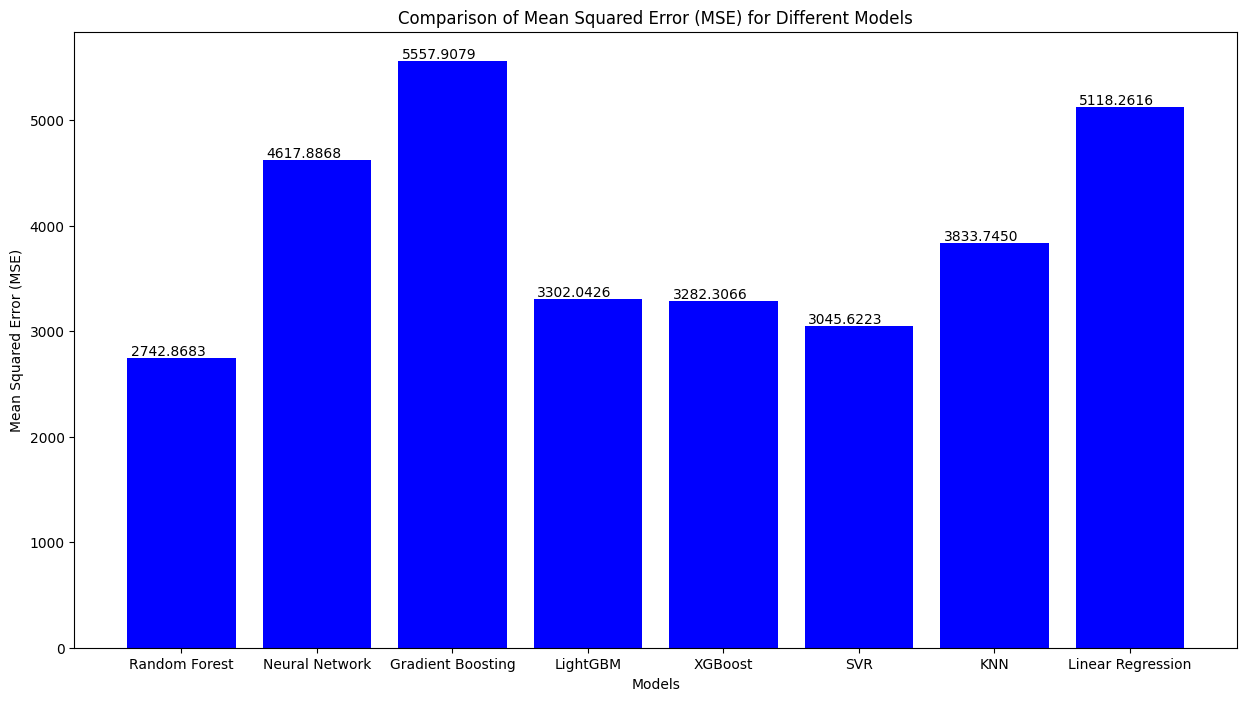

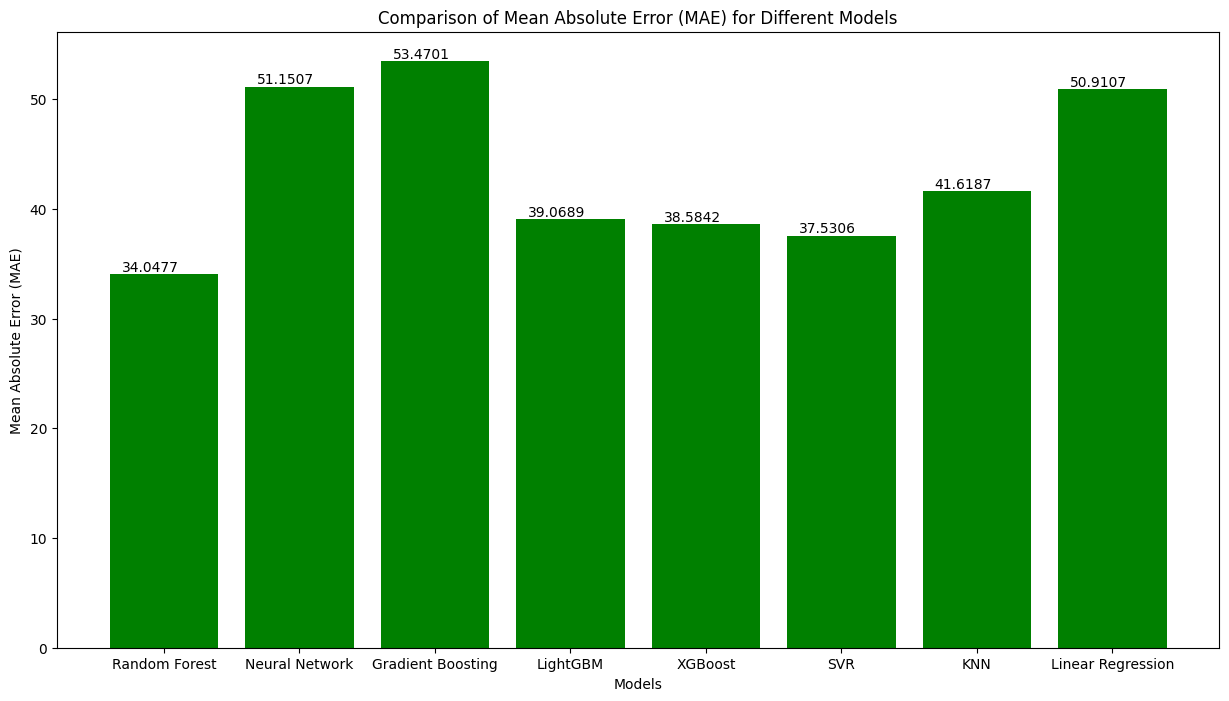

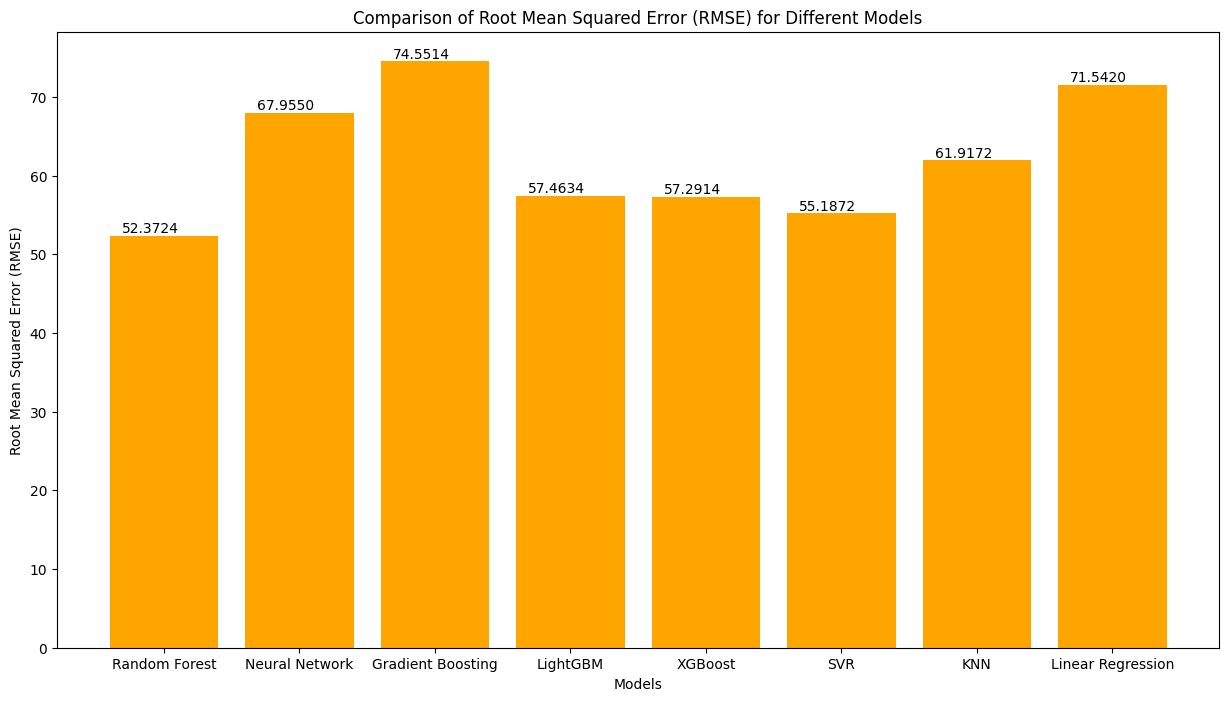

In [36]:
# Calculate MAE and RMSE for each model
mae_values = [mean_absolute_error(y_test, y_pred_single_rf),
              mean_absolute_error(y_test, y_pred_single_NN),
              mean_absolute_error(y_test, y_pred_single_gb),
              mean_absolute_error(y_test, y_pred_single_lgb),
              mean_absolute_error(y_test, y_pred_single_XGB),
              mean_absolute_error(y_test, y_pred_svr_single),
              mean_absolute_error(y_test, y_pred_knn_single),
              mean_absolute_error(y_test, y_pred_single_lr)]

rmse_values = [np.sqrt(mean_squared_error(y_test, y_pred_single_rf)),
               np.sqrt(mean_squared_error(y_test, y_pred_single_NN)),
               np.sqrt(mean_squared_error(y_test, y_pred_single_gb)),
               np.sqrt(mean_squared_error(y_test, y_pred_single_lgb)),
               np.sqrt(mean_squared_error(y_test, y_pred_single_XGB)),
               np.sqrt(mean_squared_error(y_test, y_pred_svr_single)),
               np.sqrt(mean_squared_error(y_test, y_pred_knn_single)),
               np.sqrt(mean_squared_error(y_test, y_pred_single_lr))]

models = ['Random Forest', 'Neural Network', 'Gradient Boosting', 'LightGBM', 'XGBoost', 'SVR', 'KNN', 'Linear Regression']

# Iterate over models and metrics
for m, mae, rmse in zip(models, mae_values, rmse_values):
    print(f'Model: {m}, MAE: {mae:.4f}, RMSE: {rmse:.4f}')

# Create a bar plot for MSE
plt.figure(figsize=(15, 8))
bars = plt.bar(models, single_mse, color='blue')
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Mean Squared Error (MSE) for Different Models')

# Add MSE values on top of the bars
for bar, value in zip(bars, single_mse):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f'{value:.4f}', ha='center', va='bottom')

plt.show()

# Create a bar plot for MAE
plt.figure(figsize=(15, 8))
bars = plt.bar(models, mae_values, color='green')
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Comparison of Mean Absolute Error (MAE) for Different Models')

# Add MAE values on top of the bars
for bar, value in zip(bars, mae_values):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f'{value:.4f}', ha='center', va='bottom')

plt.show()

# Create a bar plot for RMSE
plt.figure(figsize=(15, 8))
bars = plt.bar(models, rmse_values, color='orange')
plt.xlabel('Models')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Comparison of Root Mean Squared Error (RMSE) for Different Models')

# Add RMSE values on top of the bars
for bar, value in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f'{value:.4f}', ha='center', va='bottom')

plt.show()

# Multi-step


In [37]:
#train/split

window = 6
horizon = 3

X, y = sliding_window(df['load'], window, horizon)

split_ratio = 0.8
split_index = int(split_ratio * len(df))

print(X.shape)
print(y.shape)

X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]


(26297, 6)
(26297,)


### KNN


In [38]:
# # Store MSE values for different numbers of neighbors
# mse_values = []

# # Test multiple numbers of neighbors
# for n_neighbors in range(3, 32, 2):  # Odd numbers from 3 to 31
#     # KNN model
#     knn_model = KNeighborsRegressor(n_neighbors=n_neighbors)
#     knn_model.fit(X_train, y_train)

#     # Predictions on the test set
#     y_pred_knn = knn_model.predict(X_test)

#     # Calculate MSE
#     mse_knn = mean_squared_error(y_test, y_pred_knn)
#     mse_values.append((n_neighbors, mse_knn))
#     print(f'KNN Test MSE with {n_neighbors} neighbors: {mse_knn}')

# # Extract values for plotting
# neighbors, mse_values = zip(*mse_values)

# # Plot the MSE values in a bar plot
# plt.bar(neighbors, mse_values, color='blue')
# plt.xlabel('Number of Neighbors')
# plt.ylabel('Mean Squared Error')
# plt.title('MSE for Different Numbers of Neighbors')
# plt.show()

In [39]:
# KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predictions on the test set
y_pred_knn_multi = knn_model.predict(X_test)

# Calculate MSE
mse_knn_multi = mean_squared_error(y_test, y_pred_knn_multi)
print(f'KNN Test MSE: {mse_knn_multi}')

KNN Test MSE: 38566.23669331811


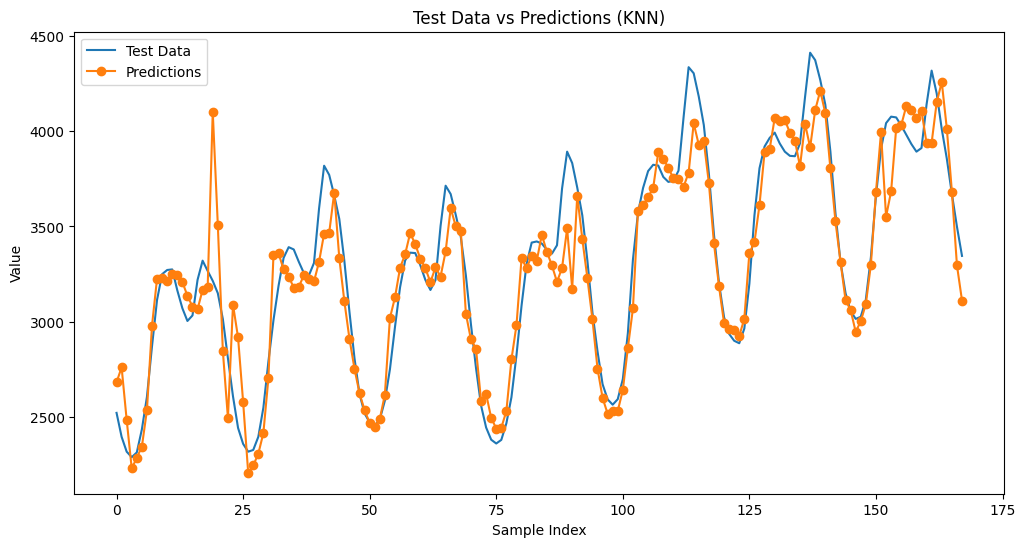

In [40]:
# Plotting the last 200 rows of actual test data and predictions
last_week = -168

plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Test Data' )
plt.plot(y_pred_knn_multi[last_week:], label='Predictions', marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test Data vs Predictions (KNN)')
plt.legend()
plt.show()

### SVR

In [41]:
# SVR requires feature scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.flatten().reshape(-1, 1)).flatten()

X_test_scaled = scaler_X.transform(X_test)

# SVR model
svr_model = SVR(kernel='rbf')  # Radial basis function (RBF) kernel
svr_model.fit(X_train_scaled, y_train_scaled)

# Predictions on the scaled test set
y_pred_svr_scaled = svr_model.predict(X_test_scaled)

# Invert scaling for comparison
y_pred_svr_multi = scaler_y.inverse_transform(y_pred_svr_scaled.reshape(-1, 1))

# Calculate MSE
mse_svr_multi = mean_squared_error(y_test.flatten(), y_pred_svr_multi)
print(f'SVR Test MSE: {mse_svr_multi}')

SVR Test MSE: 41893.59586019008


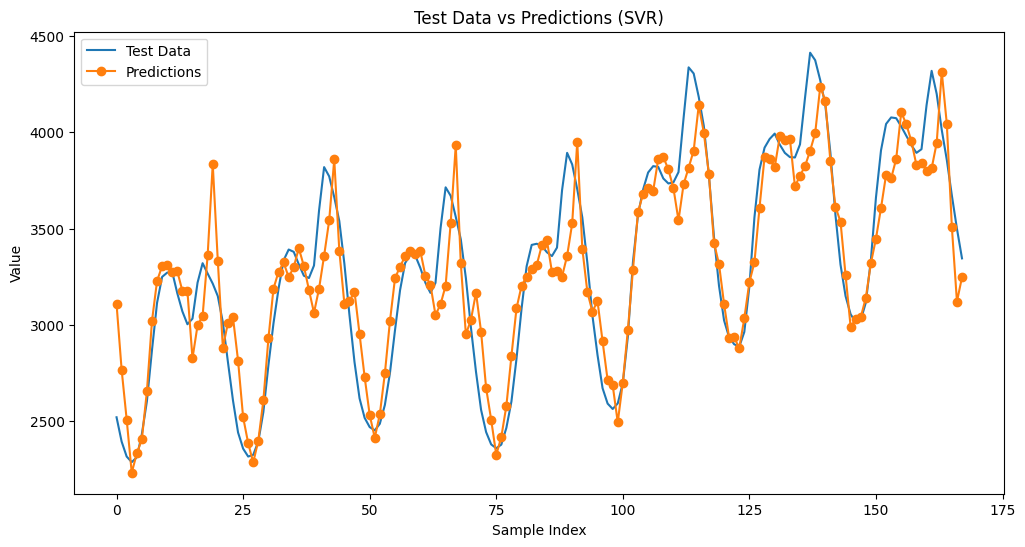

In [42]:
# Plotting the last 200 rows of actual test data and predictions
last_week = -168

plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Test Data' )
plt.plot(y_pred_svr_multi[last_week:], label='Predictions', marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test Data vs Predictions (SVR)')
plt.legend()
plt.show()

### XGBoost

In [43]:
# Create and train an XGBoost model
model = xgb.XGBRegressor(objective ='reg:squarederror') # you can customize parameters based on your problem
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_multi_xgb = model.predict(X_test)

# Evaluate the model on the test set
mse_multi_xgb = mean_squared_error(y_test, y_pred_multi_xgb)
print(f'Mean Squared Error on Test Set(XGBoost): {mse_multi_xgb}')

Mean Squared Error on Test Set(XGBoost): 37267.42068784062


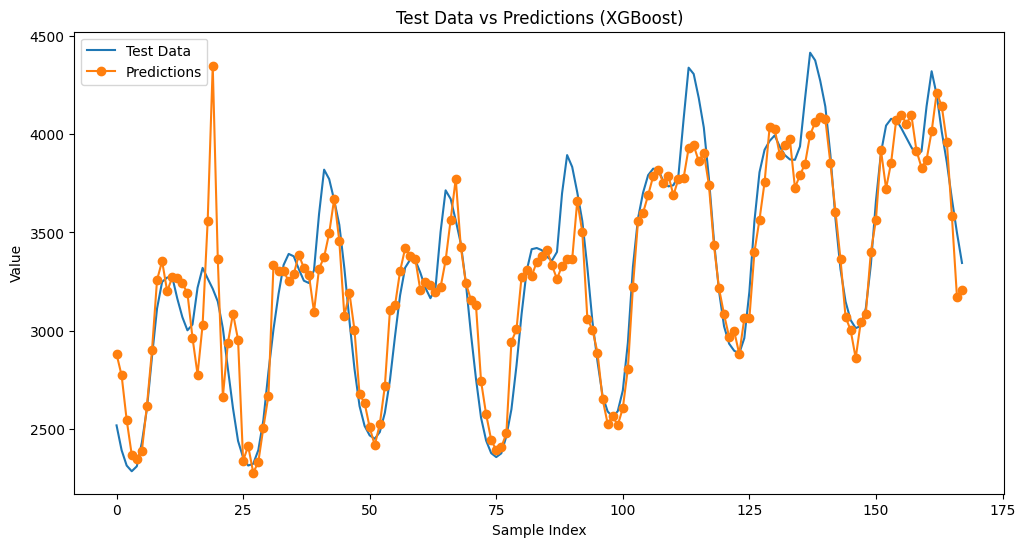

In [44]:
# Plotting the last 200 rows of actual test data and predictions
last_week = -168

plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Test Data' )
plt.plot(y_pred_multi_xgb[last_week:], label='Predictions', marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test Data vs Predictions (XGBoost)')
plt.legend()
plt.show()

### NN

In [45]:
# Standardize the input features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).flatten()

# Create a neural network regressor model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer with 1 neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2)

# Make predictions on the test set
y_pred_multi_NN = model.predict(X_test_scaled).flatten()

y_pred_multi_NN = scaler.inverse_transform(y_pred_multi_NN.reshape(-1, 1)).flatten()


# Evaluate the model on the test set
mse_multi_NN = mean_squared_error(y_test, y_pred_multi_NN)
print(f'Mean Squared Error on Test Set: {mse_multi_NN}')

Epoch 1/50
527/527 [==============================] - 2s 3ms/step - loss: 0.0146 - val_loss: 0.0091
Epoch 2/50
527/527 [==============================] - 1s 2ms/step - loss: 0.0076 - val_loss: 0.0086
Epoch 3/50
527/527 [==============================] - 1s 3ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 4/50
527/527 [==============================] - 1s 2ms/step - loss: 0.0054 - val_loss: 0.0054
Epoch 5/50
527/527 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0062
Epoch 6/50
527/527 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0071
Epoch 7/50
527/527 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 8/50
527/527 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0064
Epoch 9/50
527/527 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 10/50
527/527 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0068

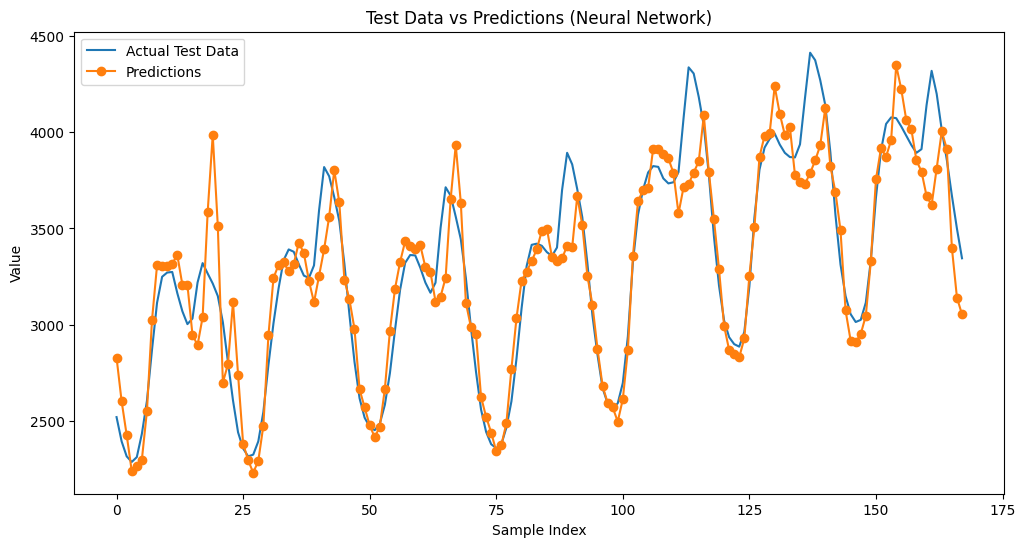

In [46]:
# Plotting the last 200 rows of actual test data and predictions
last_week = -168

plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Actual Test Data')
plt.plot(y_pred_multi_NN[last_week:], label='Predictions', marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test Data vs Predictions (Neural Network)')
plt.legend()
plt.show()

### Linear Regression

In [47]:
# Create and train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_multi_lr = model.predict(X_test)

# Evaluate the model on the test set
mse_multi_lr = mean_squared_error(y_test, y_pred_multi_lr)
print(f'Mean Squared Error on Test Set(Linear regression): {mse_multi_lr}')

Mean Squared Error on Test Set(Linear regression): 75541.25524737431


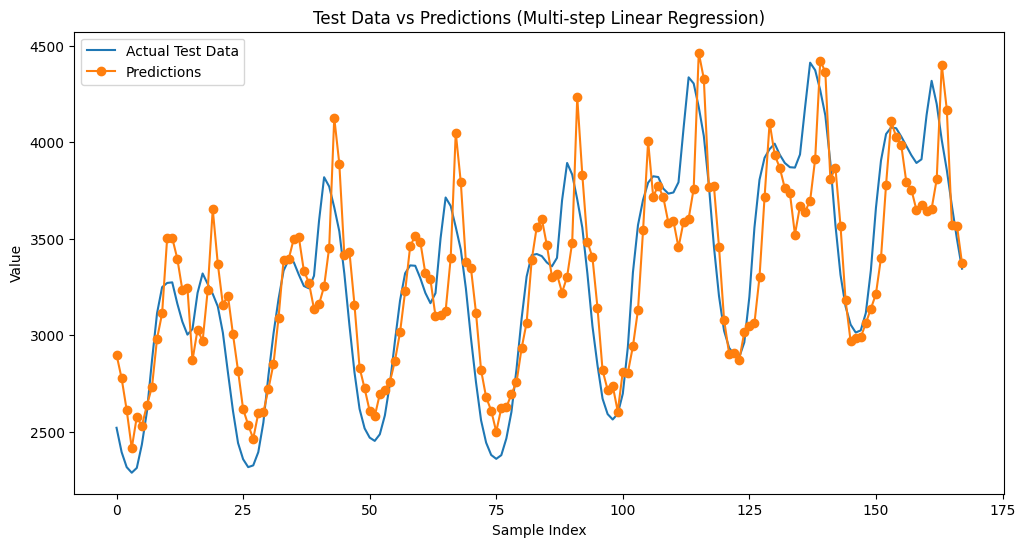

In [57]:
#ploting linear regresison
last_week = -168

plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Actual Test Data' )
plt.plot(y_pred_multi_lr[last_week:], label='Predictions',  marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test Data vs Predictions (Multi-step Linear Regression)')
plt.legend()
plt.show()

### GB

In [49]:
# Create and train a Gradient Boosting model
model_gb = GradientBoostingRegressor()  # You can customize parameters based on your problem
model_gb.fit(X_train, y_train)

# Make predictions on the test set
y_pred_multi_gb = model_gb.predict(X_test)

# Evaluate the model on the test set
mse_multi_gb = mean_squared_error(y_test, y_pred_multi_gb)
print(f'Mean Squared Error on Test Set (Gradient Boosting): {mse_multi_gb}')

Mean Squared Error on Test Set (Gradient Boosting): 56575.70587523874


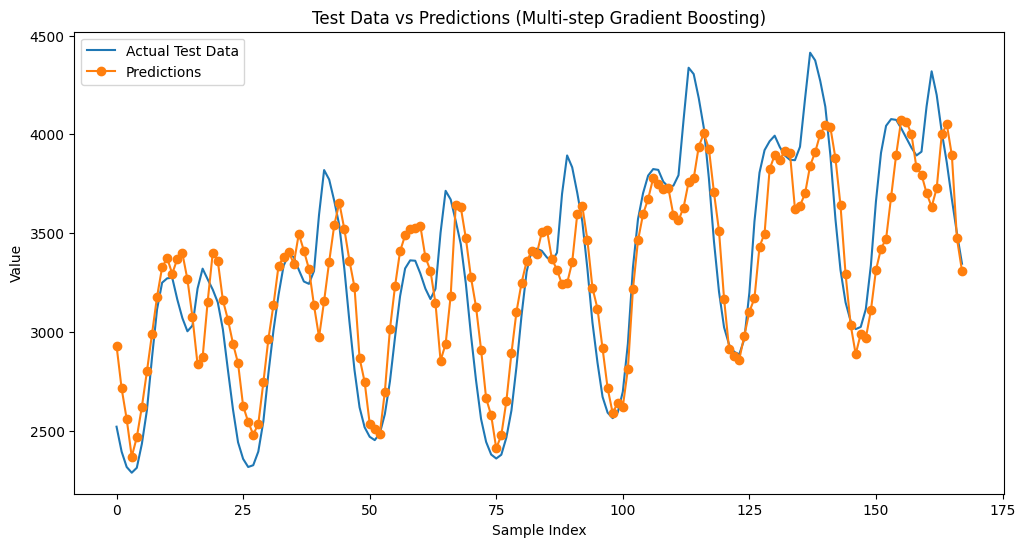

In [50]:
#ploting linear regresison
last_week = -168

plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Actual Test Data' )
plt.plot(y_pred_multi_gb[last_week:], label='Predictions',  marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test Data vs Predictions (Multi-step Gradient Boosting)')
plt.legend()
plt.show()

### LGB


In [51]:
# Create and train a LightGBM model
model_lgb = lgb.LGBMRegressor(objective='regression', metric='mse')  # You can customize parameters based on your problem
model_lgb.fit(X_train, y_train)

# Make predictions on the test set
y_pred_multi_lgb = model_lgb.predict(X_test)

# Evaluate the model on the test set
mse_multi_lgb = mean_squared_error(y_test, y_pred_multi_lgb)
print(f'Mean Squared Error on Test Set (LightGBM): {mse_multi_lgb}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 21044, number of used features: 6
[LightGBM] [Info] Start training from score 3301.732465
Mean Squared Error on Test Set (LightGBM): 39104.7034796462


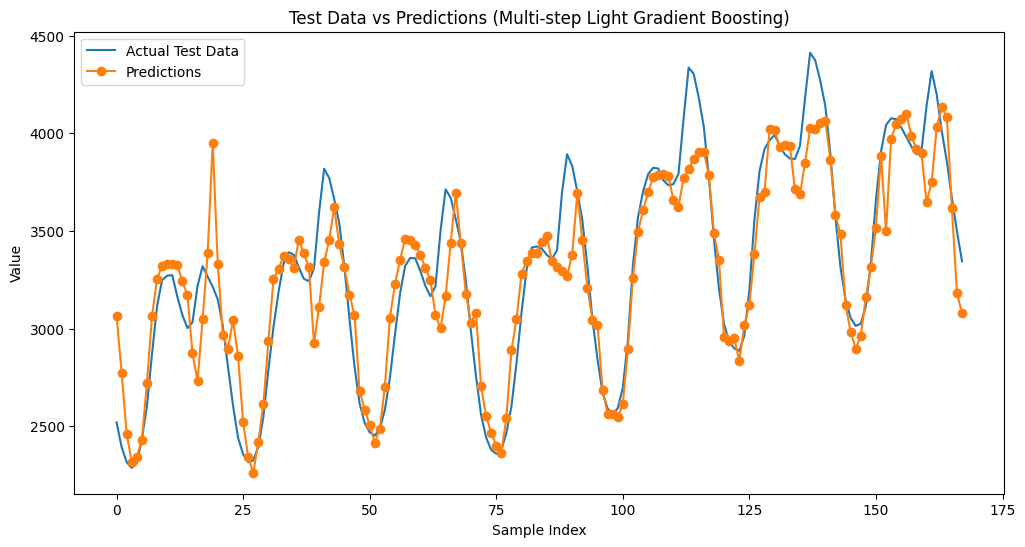

In [52]:
#ploting linear regresison
last_week = -168

plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Actual Test Data' )
plt.plot(y_pred_multi_lgb[last_week:], label='Predictions',  marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test Data vs Predictions (Multi-step Light Gradient Boosting)')
plt.legend()
plt.show()

### Random forest

In [53]:
# Train Random Forest Regressor
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
y_pred_multi_rf = model_rf.predict(X_test)

# Evaluate the model on the test set
mse_multi_random = mean_squared_error(y_test, y_pred_multi_rf)
print(f'Mean Squared Error on Test Set(Random Forest): {mse_multi_random}')

Mean Squared Error on Test Set(Random Forest): 33996.538702508085


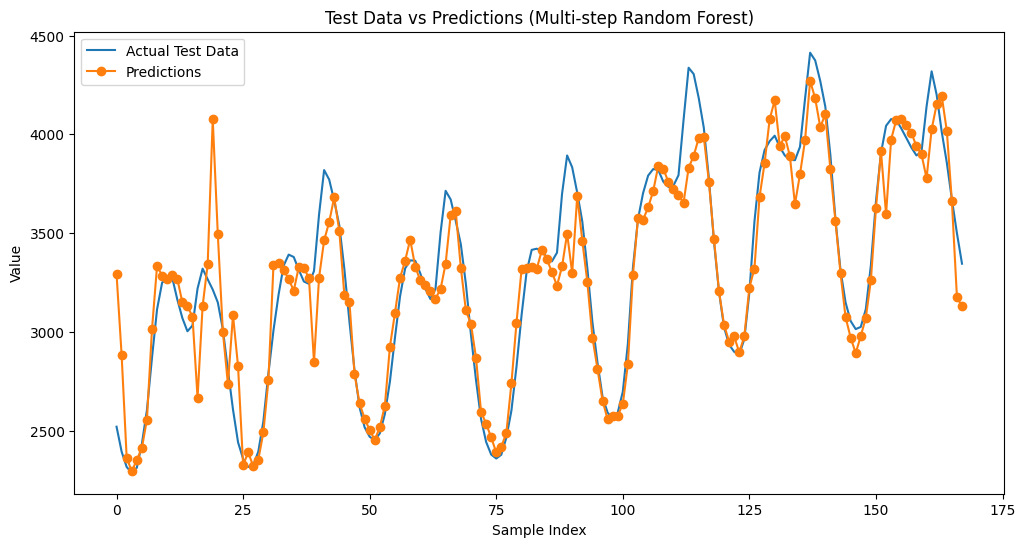

In [54]:
#ploting linear regresison
last_week = -168

plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Actual Test Data' )
plt.plot(y_pred_multi_rf[last_week:], label='Predictions',  marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test Data vs Predictions (Multi-step Random Forest)')
plt.legend()
plt.show()

## MSE/MAE/RMSE Comparison (Multi-step)

Model: Random Forest
Mean Squared Error (MSE): 33996.5387
Mean Absolute Error (MAE): 113.2734
Root Mean Squared Error (RMSE): 184.3815


Model: LightGBM
Mean Squared Error (MSE): 39104.7035
Mean Absolute Error (MAE): 132.4524
Root Mean Squared Error (RMSE): 197.7491


Model: Gradient Boosting
Mean Squared Error (MSE): 56575.7059
Mean Absolute Error (MAE): 173.9081
Root Mean Squared Error (RMSE): 237.8565


Model: Linear Regression
Mean Squared Error (MSE): 75541.2552
Mean Absolute Error (MAE): 211.6850
Root Mean Squared Error (RMSE): 274.8477


Model: Neural Network
Mean Squared Error (MSE): 31242.0768
Mean Absolute Error (MAE): 115.5911
Root Mean Squared Error (RMSE): 176.7543


Model: XGBoost
Mean Squared Error (MSE): 37267.4207
Mean Absolute Error (MAE): 124.7863
Root Mean Squared Error (RMSE): 193.0477


Model: SVR
Mean Squared Error (MSE): 41893.5959
Mean Absolute Error (MAE): 133.5920
Root Mean Squared Error (RMSE): 204.6793


Model: KNN
Mean Squared Error (MSE): 38566.2367
Mean 

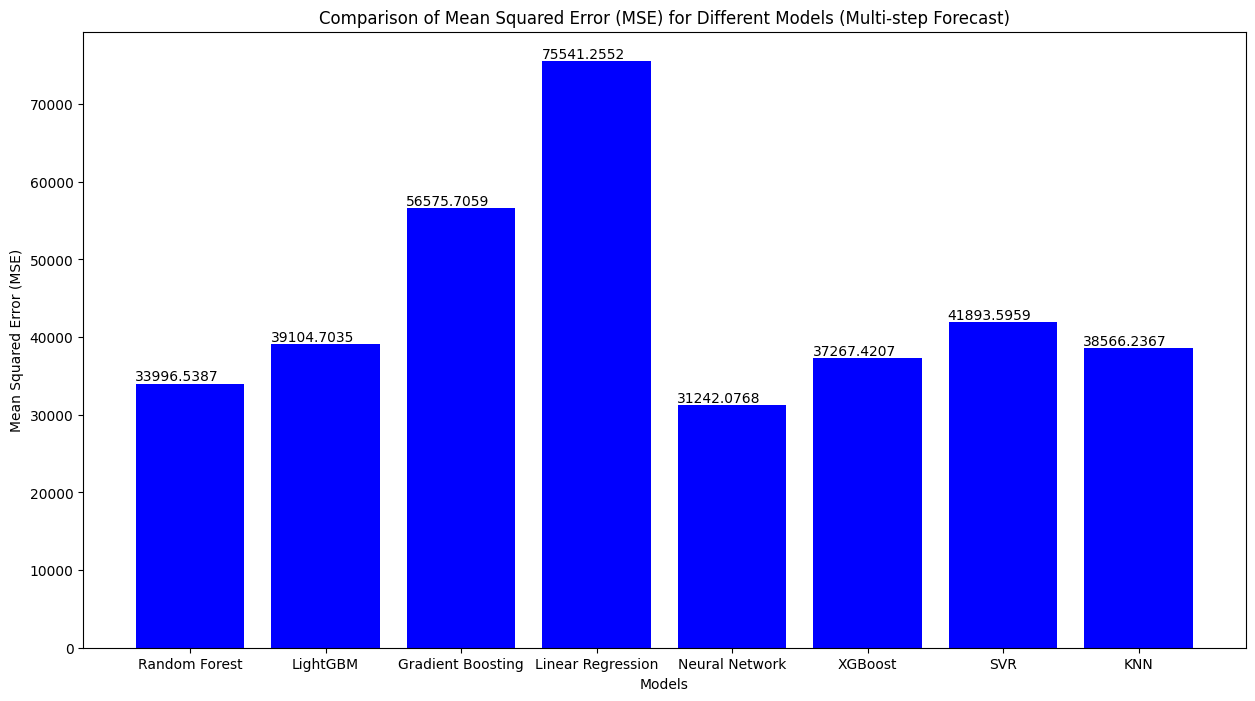

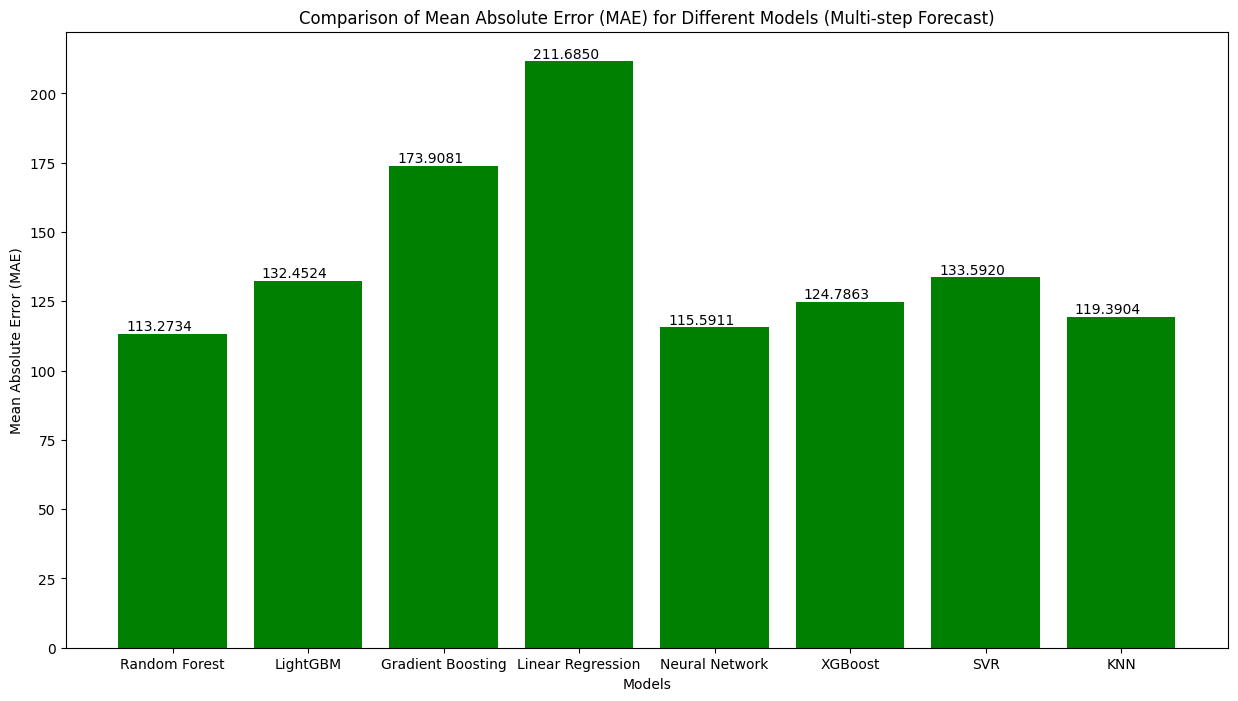

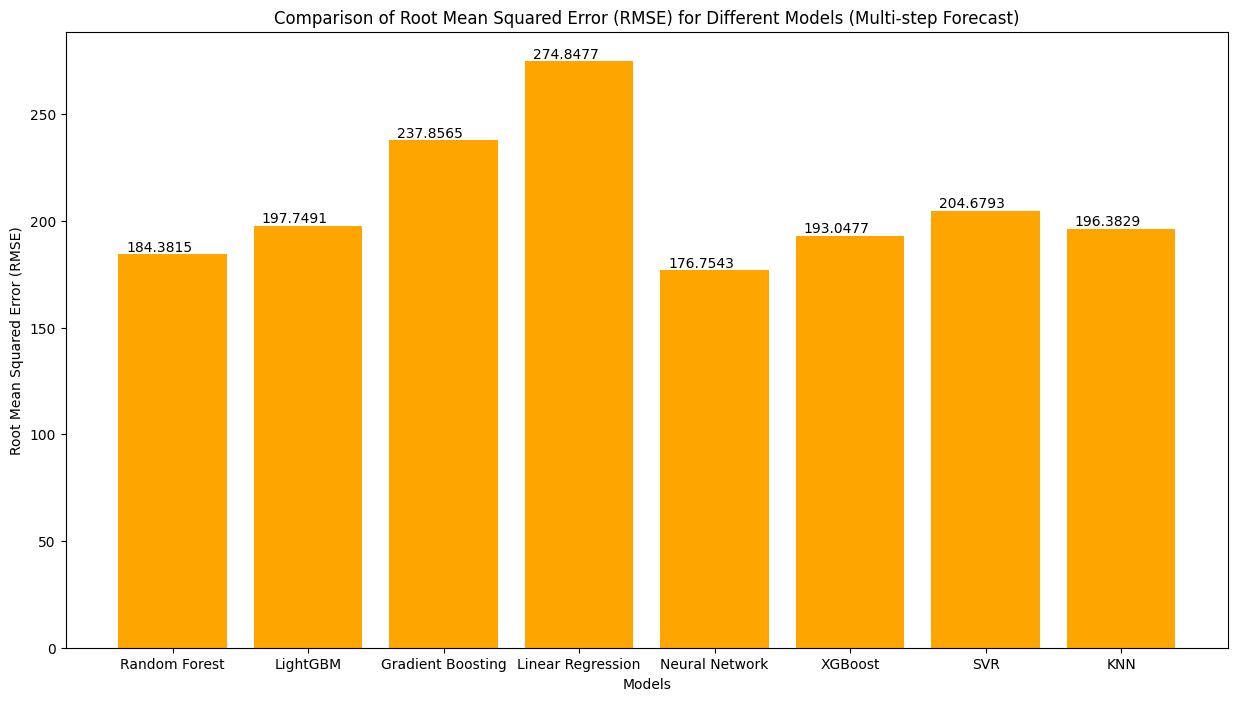

In [58]:
# Multi-step MSE values
multi_mse = [mse_multi_random, mse_multi_lgb, mse_multi_gb, mse_multi_lr, mse_multi_NN, mse_multi_xgb, mse_svr_multi, mse_knn_multi]

# Calculate MAE and RMSE for each model
mae_values = [mean_absolute_error(y_test, y_pred_multi_rf),
              mean_absolute_error(y_test, y_pred_multi_lgb),
              mean_absolute_error(y_test, y_pred_multi_gb),
              mean_absolute_error(y_test, y_pred_multi_lr),
              mean_absolute_error(y_test, y_pred_multi_NN),
              mean_absolute_error(y_test, y_pred_multi_xgb),
              mean_absolute_error(y_test.flatten(), y_pred_svr_multi),
              mean_absolute_error(y_test, y_pred_knn_multi)]

rmse_values = [np.sqrt(mean_squared_error(y_test, y_pred_multi_rf)),
               np.sqrt(mean_squared_error(y_test, y_pred_multi_lgb)),
               np.sqrt(mean_squared_error(y_test, y_pred_multi_gb)),
               np.sqrt(mean_squared_error(y_test, y_pred_multi_lr)),
               np.sqrt(mean_squared_error(y_test, y_pred_multi_NN)),
               np.sqrt(mean_squared_error(y_test, y_pred_multi_xgb)),
               np.sqrt(mean_squared_error(y_test.flatten(), y_pred_svr_multi)),
               np.sqrt(mean_squared_error(y_test, y_pred_knn_multi))]

models = ['Random Forest', 'LightGBM', 'Gradient Boosting', 'Linear Regression', 'Neural Network', 'XGBoost', 'SVR', 'KNN']

# Print metrics for each model
for model, mse, mae, rmse in zip(models, multi_mse, mae_values, rmse_values):
    print(f'Model: {model}')
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print('\n')

# Create a bar plot for MSE
plt.figure(figsize=(15, 8))
bars = plt.bar(models, multi_mse, color='blue')
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Mean Squared Error (MSE) for Different Models (Multi-step Forecast)')

# Add MSE values on top of the bars
for bar, value in zip(bars, multi_mse):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f'{value:.4f}', ha='center', va='bottom')

plt.show()

# Create a bar plot for MAE
plt.figure(figsize=(15, 8))
bars = plt.bar(models, mae_values, color='green')
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Comparison of Mean Absolute Error (MAE) for Different Models (Multi-step Forecast)')

# Add MAE values on top of the bars
for bar, value in zip(bars, mae_values):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f'{value:.4f}', ha='center', va='bottom')

plt.show()

# Create a bar plot for RMSE
plt.figure(figsize=(15, 8))
bars = plt.bar(models, rmse_values, color='orange')
plt.xlabel('Models')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Comparison of Root Mean Squared Error (RMSE) for Different Models (Multi-step Forecast)')

# Add RMSE values on top of the bars
for bar, value in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f'{value:.4f}', ha='center', va='bottom')

plt.show()